In [37]:
#Import the stuff that is done by now

from IPython.display import display

import time
import importlib
import sys
try:
    importlib.reload(sys.modules['simulation'])
    importlib.reload(sys.modules['baseline_dijkstra'])
    importlib.reload(sys.modules['initialize_agents'])
    importlib.reload(sys.modules['initialize_graph'])
except KeyError:
    pass

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import random as rd
import numpy as np

from copy import deepcopy

from initialize_graph import create_weighted_random_graph, draw_graph
from initialize_agents import Agent, create_list_of_agents

from baseline_dijkstra import find_index_2_levels, calculate_subjective_weight_for_edge_time,\
calculate_subjective_weight_for_edge_time_overall, dijkstra_with_time_dependent_weights, get_path, get_discount

from simulation import simulation_baseline
from simulation import simulation_navigator
from simulation import simulation_PTA
from simulation import dynamic_system

from testing import check_paths_and_travel_times
from testing import check_FIFO_property_baseline
from testing import check_expectations
from testing import check_reality

In [38]:
# Initialize graph
G = create_weighted_random_graph(n_nodes = 5, 
                                 n_edges = 15, 
                                 weights_from = 10, 
                                 weights_to = 30)

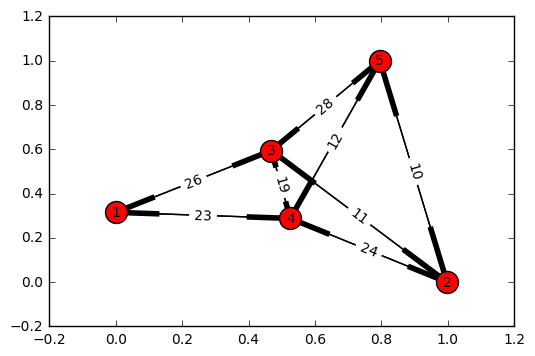

In [39]:
# Draw graph
draw_graph(G, 'spectral')

In [40]:
# Initialize agents
agents = create_list_of_agents(num_agents = 700, 
                               graph = G, 
                               time_stamp = 0.01,
                               navi_user_prob = 1,
                               PTA_user_prob = 1)

In [14]:
# Initialize simulation
simulation = simulation_baseline(G, agents, max_time = 24)

In [15]:
# Make simulation
simulation.restore_all_agents_finally()
simulation.simulation_optimized(max_iters = 100)

End of iteration 0 . Time elapsed: 4.38 sec
End of iteration 1 . Time elapsed: 4.66 sec
End of iteration 2 . Time elapsed: 5.03 sec
End of iteration 3 . Time elapsed: 5.67 sec
End of iteration 4 . Time elapsed: 5.77 sec
End of iteration 5 . Time elapsed: 6.01 sec
End of iteration 6 . Time elapsed: 6.24 sec
End of iteration 7 . Time elapsed: 6.74 sec
End of iteration 8 . Time elapsed: 6.13 sec
End of iteration 9 . Time elapsed: 6.32 sec
End of iteration 10 . Time elapsed: 6.39 sec
End of iteration 11 . Time elapsed: 6.52 sec
Agents paths converged to user-equilibrium
End of iteration 12 . Time elapsed: 6.69 sec
End of simulation . Time elapsed: 76.82 sec


In [17]:
#Comparison of total travel times: Baseline through iterations
def compare_results_base(base):
    overall_base_list = []
    for iteration in range(len(base.common_sense)):
        overall_base = 0
        for i in range(len(base.common_sense[iteration])):
            for p in range(len(base.common_sense[iteration][i].paths)):
                overall_base += base.common_sense[iteration][i].real_edge_times[p][-1][-1] \
                - base.common_sense[iteration][i].real_edge_times[p][0][0]
        overall_base_list.append(round(overall_base, 2))
    return overall_base_list
display(compare_results_base(simulation))
#display(simulation.paths_changed)

[937.64,
 983.43,
 962.04,
 938.93,
 937.97,
 936.77,
 937.4,
 936.87,
 937.37,
 935.99,
 937.01,
 936.88,
 936.88]

In [29]:
a = 1

In [ ]:
# Statistical info checks

In [ ]:
# Find agent who came or left the edge at time = t
def find_agent_time(simulation, time, iteration):
    for a in simulation.common_sense[iteration]:
        for p in range(len(a.paths)):
            for edge_num in range(len(a.paths[p])-1):
                if a.real_edge_times[p][edge_num][0] == time:
                    print('ID', a.id_num, 'Path', p, 'Edge', (a.paths[p][edge_num], a.paths[p][edge_num+1]))
find_agent_time(simulation = simulation, time = 13.72, iteration = 9)

In [ ]:
# Check to see id's of agents who arrive later than some time (currently 28)
for iteration in range(len(simulation.common_sense)):
    for a in simulation.common_sense[iteration]:
        for p in range(len(a.paths)):
            for edge in range(len(a.real_edge_times[p])):
                if a.real_edge_times[p][edge][1] >= 24:
                    print('Iteration', iteration, 'ID', a.id_num, 'Path', p)

In [ ]:
# Function that outputs the id's of agents whose expectations about travel times for a trip
# are confronted by reality and the difference between them is more than value
# Works as intended only for iter == 0

def differences_between_expectations_and_reality(agents, value):
    for a in agents:
        for p in range(len(a.paths)):
            for edge in range(len(a.real_edge_times[p])):
                if a.real_edge_times[p][edge][1] - a.expected_edge_times[p][edge][1] >= value:
                    print('ID', a.id_num, 'Path', p)
                    
differences_between_expectations_and_reality(agents = simulation.common_sense[0], value = 1.4)

In [ ]:
# Prints info about i'th agent in iteration's simulation

iteration = 0
i = 2
print('------AGENT %s------' %i)
print('Num of trips', simulation.common_sense[iteration][i].num_trips)
print('Paths', simulation.common_sense[iteration][i].paths)
print('Departures', simulation.common_sense[iteration][i].times_of_departures)
print('---------------------------------------------------------------------------------------------------')
print('Expected_edge_times', simulation.common_sense[iteration][i].expected_edge_times)
print('---------------------------------------------------------------------------------------------------')
print('real_edge_times', simulation.common_sense[iteration][i].real_edge_times)
print('---------------------------------------------------------------------------------------------------')
print('Speed by time', simulation.common_sense[iteration][i].speed_by_time)
print('---------------------------------------------------------------------------------------------------')
print('Edges passed', simulation.common_sense[iteration][i].edges_passed)
print('---------------------------------------------------------------------------------------------------')
print('Original departures', simulation.common_sense[iteration][i].original_times_of_departures)

In [ ]:
# Outputs the id's of agents whose real_travel_times changed from previous to current iteration

counter_overall = [0]*(len(simulation.common_sense)-1)
counter_agents = [[0]*len(simulation.common_sense[0]) for i in range(len(simulation.common_sense)-1)]
for iteration in range(1,len(simulation.common_sense)):
    for a in simulation.common_sense[iteration]:
        for p in range(0,len(a.paths)):
            if a.real_edge_times[p][0][0] - a.real_edge_times[p][-1][1] != \
            simulation.common_sense[iteration-1][a.id_num].real_edge_times[p][0][0]\
            - simulation.common_sense[iteration-1][a.id_num].real_edge_times[p][-1][1]:
                #print('Iteration', iteration, 'ID', a.id_num, 'Path', p)
                counter_overall[iteration-1] += 1
                counter_agents[iteration-1][a.id_num] += 1

print('--------------------------------------------------------------------')
# Counter shows how many trips per iteration were influenced by the changes 
# in paths of others (or the agent himself).
print('Counter:', counter_overall)

counter_agents_out = [0]*len(counter_agents)
for i in range(len(counter_agents)):
    for id_num in range(len(counter_agents[i])):
        if counter_agents[i][id_num] != 0:
            counter_agents_out[i] += 1
# This counter shows how many agents per iteration experienced changes in times of trips
print('Counter for agents', counter_agents_out)

In [ ]:
#Simulation navigator
for a in agents:
    a.navigator_user = np.random.choice((True, False), p = [0.5, 0.5])
    a.PTA_user = np.random.choice((True, False), p = [0.5, 0.5])

In [ ]:
#Initialize simulation navigator
simulation2 = simulation_navigator(graph = G, agents = agents, max_time = simulation.max_time, \
                                   common_sense = deepcopy(simulation.common_sense))

In [ ]:
#Make simulation
simulation2.restore_all_agents_finally()
simulation2.simulation_optimized(max_iters = 20)

In [ ]:
#Simulation PTA
for a in agents:
    a.navigator_user = np.random.choice((True, False), p = [1.0, 0.0])
    a.PTA_user = np.random.choice((True, False), p = [1.0, 0.0])

In [ ]:
#Initialize simulation
simulation3 = simulation_PTA(graph = G, agents = agents, max_time = simulation2.max_time, \
               historical_data = simulation2.statistics[0], \
               common_sense = deepcopy(simulation.common_sense), \
               cars_ahead = simulation2.cars_ahead)

In [ ]:
#Make simulation
simulation3.restore_all_agents_finally()
simulation3.simulation_optimized(max_iters = 15)

In [ ]:
#Statistical info checks for all 3 simulations

In [ ]:
#Comparison of number of paths of agents by the source of their assignment (Baseline vs Navi vs PTA)
counter_navi = 0
counter_base = 0
counter_PTA = 0
absolute_base = 0
absolute_navi = 0
absolute_PTA = 0
changed_paths = 0
equal = 0
p_overall = 0

for i in range(len(simulation.statistics[0])):
    for p in range(len(simulation.statistics[0][i].paths)):
        p_overall += 1
        
        diff_base = \
        simulation.statistics[0][i].real_edge_times[p][-1][-1] \
        - simulation.statistics[0][i].real_edge_times[p][0][0]
        
        diff_navi = \
        simulation2.statistics[0][i].real_edge_times[p][-1][-1] \
        - simulation2.statistics[0][i].real_edge_times[p][0][0]
        
        diff_PTA = \
        simulation3.statistics[0][i].real_edge_times[p][-1][-1] \
        - simulation3.statistics[0][i].real_edge_times[p][0][0]

        min_val = min(diff_base, diff_navi, diff_PTA)
        if min_val == diff_base:
            counter_base += 1
        if min_val == diff_navi:
            counter_navi += 1
        if min_val == diff_PTA:
            counter_PTA += 1
        if min_val == diff_base and min_val != diff_navi and min_val != diff_PTA:
            absolute_base += 1
        if min_val == diff_navi and min_val != diff_base and min_val != diff_PTA:
            absolute_navi += 1
        if min_val == diff_PTA and min_val != diff_base and min_val != diff_navi:
            absolute_PTA += 1
        if min_val == diff_PTA and min_val == diff_base and min_val == diff_navi:
            equal += 1
            
print('Base', counter_base, 'Absolute', absolute_base)
print('Navi', counter_navi, 'Absolute', absolute_navi)
print('PTA', counter_PTA, 'Absolute', absolute_PTA)
print('Equal times', equal)
p_overall

In [ ]:
del simulation, simulation2, simulation3

In [ ]:
#Comparison of total travel times: Baseline vs Navigator vs PTA
def compare_results(base, navi, PTA):
    overall_base = 0
    overall_navi = 0
    overall_PTA = 0
    for i in range(len(base.statistics[0])):
        for p in range(len(base.statistics[0][i].paths)):
            overall_base += base.statistics[0][i].real_edge_times[p][-1][-1] \
            - base.statistics[0][i].real_edge_times[p][0][0]
            overall_navi += navi.statistics[0][i].real_edge_times[p][-1][-1] \
            - navi.statistics[0][i].real_edge_times[p][0][0]
            overall_PTA += PTA.statistics[0][i].real_edge_times[p][-1][-1]\
            - PTA.statistics[0][i].real_edge_times[p][0][0]
    #print('Base', round(overall_base, 2))
    #print('Navi', round(overall_navi, 2))
    #print('PTA', round(overall_PTA, 2))
    return round(overall_base, 2), round(overall_navi, 2), round(overall_PTA, 2)
#compare_results(simulation, simulation2, simulation3)

In [ ]:
#Function that calculates the differences between expected and real edge times
#for every agent in a gien simulation
def get_diff_exp_real_trav_times(simulation, metric = 'full'):
    diff_list = dict((a, []) for a in range(len(simulation.statistics[0])))
    index = len(simulation.statistics) - 1
    for a in simulation.statistics[index]:
        for p in range(len(a.paths)):
            trav_time_real = a.real_edge_times[p][-1][-1] - a.real_edge_times[p][0][0]
            trav_time_exp = a.expected_edge_times[p][-1][-1] - a.expected_edge_times[p][0][0]
            diff_exp_reality = abs(trav_time_real - trav_time_exp)
            diff_list[a.id_num].append(diff_exp_reality)
    if metric == 'full':
        return diff_list
    elif metric == 'average':
        aver_agent = []
        for val in diff_list.values():
            aver_agent.append(sum(val)/len(val))
        return round(sum(aver_agent)/len(aver_agent), 4)
    elif metric == 'maximum':
        max_list = []
        for key, values in diff_list.items():
            max_list.append((key, max(values)))
        max_value = max(max_list, key = lambda x: x[1])
        return round(max_value[1], 3)

#print('Average difference base', get_diff_exp_real_trav_times(simulation, metric = 'average'))
#print('Average difference navi', get_diff_exp_real_trav_times(simulation2, metric = 'average'))
#print('Average difference PTA', get_diff_exp_real_trav_times(simulation3, metric = 'average'))

In [ ]:
cong_hist_data2 = dict((e, dict((t, [0, []]) for t in range(0, int(simulation3.max_time / 0.01) + 1))) \
                    for e in simulation3.graph.edges())
for a in simulation3.statistics[0]:
    for p in range(len(a.paths)):
        for edge_num in range(len(a.paths[p])-1):
            start_time = a.real_edge_times[p][edge_num][0]
            finish_time = a.real_edge_times[p][edge_num][1]
            start_time = int(round(start_time / 0.01))
            finish_time = int(round(finish_time / 0.01))
            edge = a.edges_passed[p][edge_num]
            #time_range = finish_time - start_time
            #for time in range(0, int(round(time_range / 0.01)) + 1):
            for time in range(start_time, finish_time + 1):
                cong_hist_data2[edge][time][0] += 1
                if time == finish_time:
                    cong_hist_data2[edge][time][1].append('l')

In [ ]:
for edge, time_list in cong_hist_data2.items():
    for t in range(len(time_list)):
        if cong_hist_data2[edge][t] != simulation3.trips_data[edge][t]:
            print('Time', t, 'Edge', edge)
            print('Real', cong_hist_data2[edge][t], 'Predicted', simulation3.trips_data[edge][t])

In [ ]:
#Stuff for making simulations below

In [ ]:
from multiprocessing import Pool
import pandas as pd

In [ ]:
def make_results(num_iters_per_graph, num_proportions, init_agents = 400):
    data = dict()
    G = create_weighted_random_graph(n_nodes = 5, n_edges = 15, weights_from = 10, \
                                     weights_to = 30, time_slot_size = 0.01)
    data['graph'] = G
    data_loop = [[dict() for j in range(num_proportions)] for g in range(num_iters_per_graph)]
    for i in range(num_iters_per_graph):
        agents = create_list_of_agents(num_agents = init_agents * (i + 2), graph = G, time_stamp = 0.01, 
                                   navi_user_prob = 1.0, PTA_user_prob = 1.0)
        
        simulation = simulation_baseline(G, agents, max_time = 24)
        simulation.restore_all_agents_finally()
        simulation.simulation_optimized(max_iters = 30)
        check_expectations(simulation)
        check_reality(simulation)
        check_paths_and_travel_times(simulation)
        
        for k in range(num_proportions):
            proportion = (k + 1)*(1/num_proportions)
            for a in agents:
                a.navigator_user = np.random.choice((True, False), p = [proportion, 1 - proportion])
                a.PTA_user = np.random.choice((True, False), p = [proportion, 1 - proportion])

            simulation2 = simulation_navigator(graph = G, agents = agents, max_time = simulation.max_time, \
                                   common_sense = deepcopy(simulation.common_sense))
            simulation2.restore_all_agents_finally()
            simulation2.simulation_optimized(max_iters = 10)
            check_expectations(simulation2)
            check_reality(simulation2)
            check_paths_and_travel_times(simulation2)
            data_loop[i][k]['prop_navi_users'] = simulation2.proportion_users

            simulation3 = simulation_PTA(graph = G, agents = agents, max_time = simulation2.max_time + 4, \
                       historical_data = simulation2.statistics[0], \
                       common_sense = deepcopy(simulation.common_sense), \
                       cars_ahead = simulation2.cars_ahead)
            simulation3.restore_all_agents_finally()
            simulation3.simulation_optimized(max_iters = 10)
            check_expectations(simulation3)
            check_reality(simulation3)
            check_paths_and_travel_times(simulation3)
            data_loop[i][k]['prop_PTA_users'] = simulation3.proportion_users

            data_loop[i][k]['TTT_base'] = list(compare_results(simulation, simulation2, simulation3))[0]
            data_loop[i][k]['TTT_navi'] = list(compare_results(simulation, simulation2, simulation3))[1]
            data_loop[i][k]['TTT_PTA'] = list(compare_results(simulation, simulation2, simulation3))[2]
            data_loop[i][k]['diff_base'] = get_diff_exp_real_trav_times(simulation, metric = 'average')
            data_loop[i][k]['diff_navi'] = get_diff_exp_real_trav_times(simulation2, metric = 'average')
            data_loop[i][k]['diff_PTA'] = get_diff_exp_real_trav_times(simulation3, metric = 'average')
            
            cntr = 0
            for a in simulation.agents:
                    cntr += a.num_trips
            data_loop[i][k]['path_count'] = cntr
            
            data_loop[i][k]['convergence_base'] = compare_results_base(simulation)
            data_loop[i][k]['convergence_navi'] = compare_results_base(simulation2)
            data_loop[i][k]['convergence_PTA'] = compare_results_base(simulation3)
            print('-----------------------------------------------------------------------------------')
            print('------------------------------End of proportion iteration', k, '---------------------------')
        
        #Dynamic simulation with PTA
        dynamic_simulation = dynamic_system(graph = G, agents = agents, max_time = simulation2.max_time + 4,
                                    historical_data = simulation2.statistics[0],
                                    common_sense = deepcopy(simulation.common_sense),
                                    cars_ahead = simulation2.cars_ahead, all_three = True)
        dynamic_simulation.restore_all_agents_finally()
        dynamic_simulation.simulation_optimized(max_iters = 20)
        check_expectations(dynamic_simulation)
        check_reality(dynamic_simulation)
        check_paths_and_travel_times(dynamic_simulation)
        data_loop[i][0]['decomposition'] = user_decomposition(dynamic_simulation)
        data_loop[i][0]['TTT_DS'] = list(compare_results(dynamic_simulation, simulation2, simulation3))[0]
        data_loop[i][0]['diff_DS'] = get_diff_exp_real_trav_times(dynamic_simulation, metric = 'average')
        data_loop[i][0]['convergence_DS'] = compare_results_base(dynamic_simulation)
        del dynamic_simulation
        
        #Dynamic simulation without PTA
        dynamic_simulation2 = dynamic_system(graph = G, agents = agents, max_time = simulation2.max_time + 3,
                                    historical_data = simulation2.statistics[0],
                                    common_sense = deepcopy(simulation.common_sense),
                                    cars_ahead = simulation2.cars_ahead, all_three = False)
        dynamic_simulation2.restore_all_agents_finally()
        dynamic_simulation2.simulation_optimized(max_iters = 20)
        check_expectations(dynamic_simulation2)
        check_reality(dynamic_simulation2)
        check_paths_and_travel_times(dynamic_simulation2)
        data_loop[i][0]['decomposition2'] = user_decomposition(dynamic_simulation2)
        data_loop[i][0]['TTT_DS2'] = list(compare_results(dynamic_simulation2, simulation2, simulation3))[0]
        data_loop[i][0]['diff_DS2'] = get_diff_exp_real_trav_times(dynamic_simulation2, metric = 'average')
        data_loop[i][0]['convergence_DS2'] = compare_results_base(dynamic_simulation2)
        del simulation, simulation2, simulation3, dynamic_simulation2
        print('-----------------------------------------------------------------------------------')
        print('------------------------------End of load iteration', i, '---------------------------')
   
    print('-----------------------------------------------------------------------------------')
    print('------------------------------End of arch iteration---------------------------')
    data['loop'] = data_loop
    return data

In [ ]:
st = time.time()
for f in range(1):
    data = make_results(4, 4, 400)
en = time.time()
print('Time elapsed in total', (en - st))

In [ ]:
data

In [ ]:
#Start of figure-drawing

In [ ]:
#Draw a graph on which the results were generated
fig = plt.figure(1)
#pos = nx.spectral_layout(data['graph'])
pos = nx.circular_layout(data['graph'])
nx.draw_networkx(data['graph'], pos = pos, node_size = 200, font_size = 10)
labels = nx.get_edge_attributes(data['graph'], 'weight')
nx.draw_networkx_edge_labels(data['graph'], pos = pos, edge_labels = labels, font_size = 10)
plt.axis('off')
plt.suptitle('Fig. 8: Randomly generated graph with 5 nodes, 10 edges \n and weights ranging from 10 to 30', 
             x = 0.5, y = 0.12, fontsize = 14, fontweight = 'normal')

plt.savefig('fig8.png', bbox_inches='tight')
plt.show()


In [ ]:
#Gather tha data for figure-drawing
proportion_of_PTA_users = []
proportion_of_navi_users = []
TTT_base = [[] for u in range(4)]
TTT_navi = [[] for u in range(4)]
TTT_PTA = [[] for u in range(4)]
for i in range(4):
    for k in range(len(data['loop'][i])):
        proportion_of_PTA_users.append(data['loop'][i][k]['prop_PTA_users'])
        proportion_of_navi_users.append(data['loop'][i][k]['prop_navi_users'])
        TTT_base[i].append(data['loop'][i][k]['TTT_base'])
        TTT_navi[i].append(data['loop'][i][k]['TTT_navi'])
        TTT_PTA[i].append(data['loop'][i][k]['TTT_PTA'])
#display(proportion_of_PTA_users)
#display(TTT_PTA)
#display(proportion_of_navi_users)
#display(TTT_navi)
#display(TTT_base)




In [ ]:
#Create figure with comaprison of travel times obtained by the methods studied
xlabels = np.array([0.25, 0.5, 0.75, 1.0])
fig = plt.figure(figsize = (10,7))

ax0 = plt.subplot(221)
ax0.set_title('800 agents')
plt.bar(left = xlabels - 0.03, height = TTT_base[0], width = 0.03, align='center')
plt.bar(left = xlabels, height = TTT_navi[0], width = 0.03, color = 'g', align='center')
plt.bar(left = xlabels + 0.03, height = TTT_PTA[0], width = 0.03, color = 'r', align='center')
plt.xticks(xlabels)
ax0.set_ylim(ymin = 750, ymax = 850)
plt.yticks([750, 775, 800, 825, 850])

ax1 = plt.subplot(222)
ax1.set_title('1200 agents')
plt.bar(left = xlabels - 0.03, height = TTT_base[1], width = 0.03, align='center')
plt.bar(left = xlabels, height = TTT_navi[1], width = 0.03, color = 'g', align='center')
plt.bar(left = xlabels + 0.03, height = TTT_PTA[1], width = 0.03, color = 'r', align='center')
plt.xticks(xlabels)
ax1.set_ylim(ymin = 1200, ymax = 1400)
#plt.yticks([500, 600, 800, 900])

ax2 = plt.subplot(223)
ax2.set_title('1600 agents')
plt.bar(left = xlabels - 0.03, height = TTT_base[2], width = 0.03, align='center')
plt.bar(left = xlabels, height = TTT_navi[2], width = 0.03, color = 'g', align='center')
plt.bar(left = xlabels + 0.03, height = TTT_PTA[2], width = 0.03, color = 'r', align='center')
plt.xticks(xlabels)
ax2.set_ylim(ymin = 1600, ymax = 2000)
plt.yticks([1600, 1700, 1800, 1900, 2000])

ax3 = plt.subplot(224)
ax3.set_title('2000 agents')
plt.bar(left = xlabels - 0.03, height = TTT_base[3], width = 0.03, align='center')
plt.bar(left = xlabels, height = TTT_navi[3], width = 0.03, color = 'g', align='center')
plt.bar(left = xlabels + 0.03, height = TTT_PTA[3], width = 0.03, color = 'r', align='center')
plt.xticks(xlabels)
ax3.set_ylim(ymin = 2500, ymax = 2900)
plt.yticks([2500, 2600, 2700, 2800, 2900])

plt.suptitle('Fig. 11: The performance of baseline, navigator and PTA solutions \n' \
             + 'with different number of agents in the network \n' + 
             "\n(hor. axes - proportion of method's users, vert. axes - total travel time of the system)", 
             x = 0.5, y = 0.05, fontsize = 14, fontweight = 'normal')

blue_patch = mpatches.Patch(color='blue', label='Baseline')
green_patch = mpatches.Patch(color='green', label='Navigator')
red_patch = mpatches.Patch(color='red', label='PTA')

plt.legend(handles=[blue_patch, green_patch, red_patch], 
           bbox_to_anchor=(1.1, 1.3), loc=2, borderaxespad=0.0)

plt.savefig('2fig10.png', bbox_inches='tight')
plt.show()



In [ ]:
#Gather the convergence metrics
convergence_base = []
for i in range(4):
    convergence_base.append(data['loop'][i][0]['convergence_base'])
#convergence_base
len(convergence_base[2])


In [ ]:
#Create figure with convergence metrics of dynamic simulation
fig = plt.figure(figsize = (10,7))

ax0 = plt.subplot(221)
ax0.set_title('800 agents')
plt.plot(convergence_base[0])
plt.xticks(list(range(0, len(convergence_base[0]), 1)))
#ax0.set_ylim(ymin = 410, ymax = 430)
#plt.yticks(list(range(410, 440, 5)))


ax1 = plt.subplot(222)
ax1.set_title('1200 agents')
plt.plot(convergence_base[1])
plt.xticks(list(range(0, len(convergence_base[1]), 1)))
ax1.set_ylim(ymin = 1320, ymax = 1450)
plt.yticks(list(range(1320, 1451, 30)))

ax2 = plt.subplot(223)
ax2.set_title('1600 agents')
plt.plot(convergence_base[2])
ax2.set_xlim(xmin = 0, xmax = 26)
plt.xticks(list(range(0, len(convergence_base[2]), 3)))
#ax2.set_ylim(ymin = 1200, ymax = 2000)
plt.yticks(list(range(1800, 2601, 200)))

ax3 = plt.subplot(224)
ax3.set_title('2000 agents')
plt.plot(convergence_base[3])
ax3.set_xlim(xmin = 0, xmax = 29)
plt.xticks(list(range(0, len(convergence_base[3]), 3)))
#ax3.set_ylim(ymin = 2200, ymax = 4000)
plt.yticks(list(range(2500, 5501, 750)))

plt.suptitle('Fig. 9: The convergence of baseline simulation to SUE with limit on # iterations equal to 30' 
             + "\n\n(hor. axes - number of iterations, vert. axes - total travel time of the system)", 
             x = 0.5, y = 0.05, fontsize = 14, fontweight = 'normal')

#plt.savefig('2fig9.png', bbox_inches='tight')
plt.show()


In [ ]:
#Gather the convergence metrics
convergence_PTA = []
for i in range(4):
    convergence_PTA.append(data['loop'][i][0]['convergence_PTA'][len(convergence_base[i]):])
#convergence_base
len(convergence_PTA[3])



In [ ]:
#Create figure with convergence metrics of dynamic simulation
fig = plt.figure(figsize = (10,7))

ax0 = plt.subplot(221)
ax0.set_title('800 agents')
plt.plot(convergence_PTA[0], color = 'r')
ax0.set_ylim(ymin = 820, ymax = 840)
#plt.yticks(list(range(410, 440, 5)))


ax1 = plt.subplot(222)
ax1.set_title('1200 agents')
plt.plot(convergence_PTA[1], color = 'r')
ax1.set_ylim(ymin = 1310, ymax = 1340)
#plt.yticks(list(range(1320, 1451, 30)))
y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
ax1.yaxis.set_major_formatter(y_formatter)

ax2 = plt.subplot(223)
ax2.set_title('1600 agents')
plt.plot(convergence_PTA[2], color = 'r')
ax2.set_ylim(ymin = 1860, ymax = 1900)
#plt.yticks(list(range(1800, 2601, 200)))

ax3 = plt.subplot(224)
ax3.set_title('2000 agents')
plt.plot(convergence_PTA[3], color = 'r')
ax3.set_ylim(ymin = 2700, ymax = 2900)
#plt.yticks(list(range(2500, 5501, 750)))

plt.suptitle('Fig. 10: The convergence of PTA simulation to SUE with limit on # iterations equal to 10' 
             + "\n\n(hor. axes - number of iterations, vert. axes - total travel time of the system)", 
             x = 0.5, y = 0.05, fontsize = 14, fontweight = 'normal')

#plt.savefig('2fig14.png', bbox_inches='tight')
plt.show()

In [ ]:
#Gather the convergence metrics
convergence_DS = []
convergence_DS2 = []
for i in range(4):
    convergence_DS.append(data['loop'][i][0]['convergence_DS'])
    convergence_DS2.append(data['loop'][i][0]['convergence_DS2'])
#convergence_DS2



In [ ]:
#Create figure with convergence metrics of dynamic system
fig = plt.figure(figsize = (10,7))

ax0 = plt.subplot(221)
ax0.set_title('800 agents')
plt.plot(convergence_DS[0][len(convergence_base[0]):])
plt.plot(convergence_DS2[0][len(convergence_base[0]):])
plt.xticks(list(range(0, len(convergence_DS[0][len(convergence_base[0]):]), 3)))
#ax0.set_ylim(ymin = 415, ymax = 425)
#plt.yticks(list(range(415, 426, 2)))


ax1 = plt.subplot(222)
ax1.set_title('1200 agents')
plt.plot(convergence_DS[1][len(convergence_base[1]):])
plt.plot(convergence_DS2[1][len(convergence_base[1]):])
plt.xticks(list(range(0, len(convergence_DS[1][len(convergence_base[1]):]), 3)))
#ax1.set_ylim(ymin = 800, ymax = 820)
#plt.yticks(list(range(1315, 1326, 2)))
y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
ax1.yaxis.set_major_formatter(y_formatter)

ax2 = plt.subplot(223)
ax2.set_title('1600 agents')
plt.plot(convergence_DS[2][len(convergence_base[2]):])
plt.plot(convergence_DS2[2][len(convergence_base[2]):])
plt.xticks(list(range(0, len(convergence_DS[2][len(convergence_base[2]):]), 3)))
#ax2.set_ylim(ymin = 1350, ymax = 1380)
#plt.yticks(list(range(1842, 1855, 3)))

ax3 = plt.subplot(224)
ax3.set_title('2000 agents')
plt.plot(convergence_DS[3][len(convergence_base[3]):])
plt.plot(convergence_DS2[3][len(convergence_base[3]):])
plt.xticks(list(range(0, len(convergence_DS[3][len(convergence_base[3]):]), 3)))
#ax3.set_ylim(ymin = 2100, ymax = 2200)
#plt.yticks(list(range(2100, 2201, 20)))

plt.suptitle('Fig. 12: The convergence of dynamic simulation to SUE across 20 iterations' 
             + "\n\n(hor. axes - number of iterations, vert. axes - total travel time of the system)", 
             x = 0.5, y = 0.05, fontsize = 14, fontweight = 'normal')

blue_patch = mpatches.Patch(color='blue', label='dynamic system\nwith PTA')
green_patch = mpatches.Patch(color='green', label='dynamic system\nwithout PTA')

plt.legend(handles=[blue_patch, green_patch], 
           bbox_to_anchor=(1.1, 1.3), loc=2, borderaxespad=0.0)

#plt.savefig('2fig11.png', bbox_inches='tight')
plt.show()



In [ ]:
TTT_DS = []
TTT_DS2 = []
TTT_base_prox = []
for i in range(len(data['loop'])):
    TTT_DS.append(data['loop'][i][0]['TTT_DS']/data['loop'][i][0]['path_count'])
    TTT_DS2.append(data['loop'][i][0]['TTT_DS2']/data['loop'][i][0]['path_count'])
    TTT_base_prox.append(data['loop'][i][0]['TTT_base']/data['loop'][i][0]['path_count'])
    
#display(TTT_DS)
#display(TTT_DS2)
#display(TTT_base_prox)
a = TTT_DS2[3]/TTT_base_prox[3]
b = TTT_DS[3]/TTT_base_prox[3]
c = TTT_DS[3]/TTT_DS2[3]
#a - b
c

In [ ]:
#Create figure with comaprison of travel times obtained by the methods studied
xlabels = np.array([800, 1200, 1600, 2000])
fig = plt.figure(figsize = (10,7))

ax0 = plt.subplot(221)
plt.bar(left = xlabels - 80, height = TTT_base_prox, width = 80, align='center')
plt.bar(left = xlabels, height = TTT_DS2, width = 80, color = 'g', align='center')
plt.bar(left = xlabels + 80, height = TTT_DS, width = 80, color = 'r', align='center')
ax0.set_xlabel('Number of agents')
ax0.set_ylabel('Average travel time')
plt.xticks(xlabels)
ax0.set_ylim(ymin = 0.3, ymax = 0.46)
#plt.yticks([750, 775, 800, 825, 850])

blue_patch = mpatches.Patch(color='blue', label='Only exp.')
green_patch = mpatches.Patch(color='green', label='Exp. + navigator')
red_patch = mpatches.Patch(color='red', label='Exp + navigator + PTA')

plt.suptitle("Fig. 13: The comparion of dynamic system's average travel times",
             x = 0.4, y = 0.45, fontsize = 12, fontweight = 'normal')

plt.legend(handles=[blue_patch, green_patch, red_patch], 
           bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.0, fontsize = 10)
#plt.savefig('2fig15.png', bbox_inches='tight')
plt.show()



In [ ]:
#Decomposition of number of users by method in DS
num_PTA_users = [[] for u in range(4)]
num_navi_users = [[] for u in range(4)]
num_base_users = [[] for u in range(4)]
for i in range(len(data['loop'][i])):
    for dictionary in data['loop'][i][0]['decomposition']:
        num_PTA_users[i].append(dictionary['PTA'])
        num_navi_users[i].append(dictionary['navigator'])
        num_base_users[i].append(dictionary['base'])
num_navi_users[2][1] + num_base_users[2][1] + num_PTA_users[2][1]


In [ ]:
#Create figure with convergence metrics of dynamic system
fig = plt.figure(figsize = (10,7))

ax0 = plt.subplot(221)
ax0.set_title('800 agents')
y = np.row_stack((num_PTA_users[0], num_base_users[0], num_navi_users[0]))
x = np.array(list(range(len(num_PTA_users[0]))))
plt.stackplot(x, y, colors = ('r', 'b', 'g'))
plt.xticks(list(range(0, len(num_PTA_users[0]), 3)))
plt.yticks(list(range(0, 2395, 350)))
ax0.set_ylim(ymin = 0, ymax = num_PTA_users[0][0] + num_base_users[0][0] + num_navi_users[0][0])
ax0.set_xlim(xmin = 0, xmax = len(num_base_users[0])-1)


ax1 = plt.subplot(222)
ax1.set_title('1200 agents')
y = np.row_stack((num_PTA_users[1], num_base_users[1], num_navi_users[1]))
plt.stackplot(x, y, colors = ('r', 'b', 'g'))
plt.xticks(list(range(0, len(num_PTA_users[0]), 3)))
ax1.set_ylim(ymin = 0, ymax = num_PTA_users[1][0] + num_base_users[1][0] + num_navi_users[1][0])
#plt.yticks(list(range(0, 2447, 400)))
ax1.set_xlim(xmin = 0, xmax = len(num_base_users[0])-1)

ax2 = plt.subplot(223)
ax2.set_title('1600 agents')
y = np.row_stack((num_PTA_users[2], num_base_users[2], num_navi_users[2]))
plt.stackplot(x, y, colors = ('r', 'b', 'g'))
plt.xticks(list(range(0, len(num_PTA_users[0]), 3)))
ax2.set_ylim(ymin = 0, ymax = num_PTA_users[2][0] + num_base_users[2][0] + num_navi_users[2][0])
plt.yticks(list(range(0, 4791, 600)))
ax2.set_xlim(xmin = 0, xmax = len(num_base_users[0])-1)

ax3 = plt.subplot(224)
ax3.set_title('2000 agents')
y = np.row_stack((num_PTA_users[3], num_base_users[3], num_navi_users[3]))
plt.stackplot(x, y, colors = ('r', 'b', 'g'))
plt.xticks(list(range(0, len(num_PTA_users[0]), 3)))
ax3.set_ylim(ymin = 0, ymax = num_PTA_users[3][0] + num_base_users[3][0] + num_navi_users[3][0])
#plt.yticks(list(range(0, 5022, 800)))
ax3.set_xlim(xmin = 0, xmax = len(num_base_users[0])-1)

plt.suptitle('Fig. 14: The composition of paths based on usage of routing methods with PTA as an option' 
             + "\n\n(hor. axes - number of iterations, vert. axes - total travel time of the system)", 
             x = 0.5, y = 0.05, fontsize = 14, fontweight = 'normal')

blue_patch = mpatches.Patch(color='blue', label='Baseline')
green_patch = mpatches.Patch(color='green', label='Navigator')
red_patch = mpatches.Patch(color='red', label='PTA')

plt.legend(handles=[blue_patch, green_patch, red_patch], 
           bbox_to_anchor=(1.1, 1.3), loc=2, borderaxespad=0.0)

plt.savefig('2fig12.png', bbox_inches='tight')
plt.show()



In [ ]:
#Decomposition of number of users by method in DS
num_PTA_users2 = [[] for u in range(4)]
num_navi_users2 = [[] for u in range(4)]
num_base_users2 = [[] for u in range(4)]
for i in range(len(data['loop'][i])):
    for dictionary in data['loop'][i][0]['decomposition2']:
        num_PTA_users2[i].append(dictionary['PTA'])
        num_navi_users2[i].append(dictionary['navigator'])
        num_base_users2[i].append(dictionary['base'])
num_navi_users[2][1] + num_base_users[2][1] + num_PTA_users[2][1]


In [ ]:
#Create figure with convergence metrics of dynamic system
fig = plt.figure(figsize = (10,7))

ax0 = plt.subplot(221)
ax0.set_title('800 agents')
y = np.row_stack((num_PTA_users2[0], num_base_users2[0], num_navi_users2[0]))
x = np.array(list(range(len(num_PTA_users2[0]))))
plt.stackplot(x, y, colors = ('r', 'b', 'g'))
plt.xticks(list(range(0, len(num_PTA_users2[0]), 3)))
plt.yticks(list(range(0, 2395, 350)))
ax0.set_ylim(ymin = 0, ymax = num_PTA_users2[0][0] + num_base_users2[0][0] + num_navi_users2[0][0])
ax0.set_xlim(xmin = 0, xmax = len(num_base_users2[0])-1)


ax1 = plt.subplot(222)
ax1.set_title('1200 agents')
y = np.row_stack((num_PTA_users2[1], num_base_users2[1], num_navi_users2[1]))
plt.stackplot(x, y, colors = ('r', 'b', 'g'))
plt.xticks(list(range(0, len(num_PTA_users2[0]), 3)))
ax1.set_ylim(ymin = 0, ymax = num_PTA_users2[1][0] + num_base_users2[1][0] + num_navi_users2[1][0])
#plt.yticks(list(range(0, 2447, 400)))
ax1.set_xlim(xmin = 0, xmax = len(num_base_users2[0])-1)

ax2 = plt.subplot(223)
ax2.set_title('1600 agents')
y = np.row_stack((num_PTA_users2[2], num_base_users2[2], num_navi_users2[2]))
plt.stackplot(x, y, colors = ('r', 'b', 'g'))
plt.xticks(list(range(0, len(num_PTA_users2[0]), 3)))
ax2.set_ylim(ymin = 0, ymax = num_PTA_users2[2][0] + num_base_users2[2][0] + num_navi_users2[2][0])
plt.yticks(list(range(0, 4791, 600)))
ax2.set_xlim(xmin = 0, xmax = len(num_base_users2[0])-1)

ax3 = plt.subplot(224)
ax3.set_title('2000 agents')
y = np.row_stack((num_PTA_users2[3], num_base_users2[3], num_navi_users2[3]))
plt.stackplot(x, y, colors = ('r', 'b', 'g'))
plt.xticks(list(range(0, len(num_PTA_users2[0]), 3)))
ax3.set_ylim(ymin = 0, ymax = num_PTA_users2[3][0] + num_base_users2[3][0] + num_navi_users2[3][0])
#plt.yticks(list(range(0, 5022, 800)))
ax3.set_xlim(xmin = 0, xmax = len(num_base_users2[0])-1)

plt.suptitle('Fig. 15: The composition of paths based on usage of routing methods without PTA as an option' 
             + "\n\n(hor. axes - number of iterations, vert. axes - total travel time of the system)", 
             x = 0.5, y = 0.05, fontsize = 14, fontweight = 'normal')

blue_patch = mpatches.Patch(color='blue', label='Baseline')
green_patch = mpatches.Patch(color='green', label='Navigator')

plt.legend(handles=[blue_patch, green_patch], 
           bbox_to_anchor=(1.1, 1.3), loc=2, borderaxespad=0.0)

plt.savefig('2fig13.png', bbox_inches='tight')
plt.show()


In [ ]:
#End of figure-drawing

In [ ]:
#Dynamic system

In [ ]:
dynamic_simulation = dynamic_system(graph = G, agents = agents, max_time = simulation2.max_time,
                                    historical_data = simulation2.statistics[0],
                                    common_sense = deepcopy(simulation.common_sense),
                                    cars_ahead = simulation2.cars_ahead, all_three = True)

In [ ]:
dynamic_simulation.restore_all_agents_finally()
dynamic_simulation.simulation_optimized(max_iters = 1)

In [ ]:
def user_decomposition(dynamic_simulation):    
    decomposition = \
    [dict() for a in range(dynamic_simulation.num_baseline_iters, len(dynamic_simulation.common_sense))]
    for iteration in range(dynamic_simulation.num_baseline_iters, len(dynamic_simulation.common_sense)):
        base = 0
        PTA = 0
        navi = 0
        for a in dynamic_simulation.common_sense[iteration]:
            for p in range(len(a.paths)):
                if a.path_type[p] == 'baseline':
                    base += 1
                elif a.path_type[p] == 'navigator':
                    navi += 1
                elif a.path_type[p] == 'PTA':
                    PTA += 1
        decomposition[iteration - dynamic_simulation.num_baseline_iters]['base'] = base
        decomposition[iteration - dynamic_simulation.num_baseline_iters]['navigator'] = navi
        decomposition[iteration - dynamic_simulation.num_baseline_iters]['PTA'] = PTA
    return decomposition
        #print('Base', base)
        #print('Navi', navi)
        #print('PTA', PTA)
        #print('-------------Iteration', iteration, 'ended-----------------')

In [ ]:
dec = user_decomposition(dynamic_simulation)
dec

In [ ]:
compare_results(dynamic_simulation, simulation2, simulation3)